# Research

Research class is intended for multiple running of the same pipelines with different parameters in order to get some statistics.

Let's compare `VGG7` and `VGG16` performance on `MNIST` dataset with different layouts of convolutional blocks. For each combination of layout and model class, we will train model for 500 iterations and repeat that process 2 times. 

In [2]:
!ls

Wide_ResNet_experiments.ipynb  my_research_2  my_research_6	 wide.py
initializer_experiments.ipynb  my_research_3  my_research_7
my_research		       my_research_4  plot_functions.py
my_research_1		       my_research_5  time_batch.py


In [1]:
!nvidia-smi

Wed May 30 18:24:25 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   28C    P8     5W / 180W |   7885MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   34C    P8    10W / 180W |      0MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5538065290665500310
]


In [2]:
import sys
import dill
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../..")
from dataset import Pipeline, B, C, V
from dataset.opensets import MNIST
from dataset.models.tf import VGG7, VGG16
from dataset.research import Research, Option

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
BATCH_SIZE=64

# Define pipelines

Define model config. All parameters that we want to vary we define as ``C('parameter_name')``. In our case it's a `'body/block/layout'`.

In [4]:
model_config={
    'session/config': tf.ConfigProto(allow_soft_placement=True),
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': 10, 'transform': 'ohe', 'name': 'targets'}),
    'input_block/inputs': 'images',
    'body/block/layout': C('layout'),
    'output/ops': 'accuracy',
    'device': C('device'), # it's technical parameter for TFModel
#     'common' : {'regularizer' : tf.contrib.layers.l2_regularizer(0.0001)},
}

Define loading as a separate pipeline with lazy run. This is optional.

In [5]:
mnist = MNIST()
train_root = mnist.train.p.run(BATCH_SIZE, shuffle=True, n_epochs=None, lazy=True)
test_root = mnist.test.p.run(BATCH_SIZE, shuffle=True, n_epochs=1, lazy=True)

Extracting /tmp/train-images-idx3-ubyte.gz
ExtractingExtracting /tmp/t10k-images-idx3-ubyte.gz
 /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


Now define main parts of pipelines where we want to vary model:

In [6]:
train_template = (Pipeline()
            .init_variable('loss', init_on_each_run=list)
            .init_variable('accuracy', init_on_each_run=list)
            .init_model('dynamic', C('model'), 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         fetches=['loss', 'output_accuracy'], 
                         feed_dict={'images': B('images'), 'labels': B('labels')},
                         save_to=[V('loss'), V('accuracy')], mode='w')
)

In [7]:
test_template = (Pipeline()
            .init_variable('accuracy', init_on_each_run=list)
            .import_model('conv', C('import_from'))
            .to_array()
            .predict_model('conv', 
                         fetches=['output_accuracy'], 
                         feed_dict={'images': B('images'), 'labels': B('labels')},
                         save_to=[V('accuracy')], mode='a')
)

In [8]:
train_ppl = train_root + train_template
test_ppl = test_root + test_template

All parameter combinations we define through the dict where a key is a parameter name and value is a list of possible parameter values. Create a grid of parameters in the following way:

In [9]:
grid = Option('layout', ['cna', 'can']) * Option('model', [VGG7])
# , VGG16])

You can get all variants of config:

In [10]:
list(grid.gen_configs())

[ConfigAlias({'model': 'VGG7', 'layout': 'cna'}),
 ConfigAlias({'model': 'VGG7', 'layout': 'can'})]

In [11]:
configs = list(grid.gen_configs())
configs

[ConfigAlias({'model': 'VGG7', 'layout': 'cna'}),
 ConfigAlias({'model': 'VGG7', 'layout': 'can'})]

Each element is a ConfigAlias. It's a Config dict of parameter values and dict with aliases for parameter values:

In [12]:
configs[0].config(), configs[0].alias()

(Config({'layout': 'cna', 'model': <class 'dataset.models.tf.vgg.VGG7'>}),
 {'layout': 'cna', 'model': 'VGG7'})

Note that in the first case `model` is a class but in the second `str`.

# Create Research object

Create an instance of `Research` class and add train and test pipelines and grid of parameters:

In [13]:
research = (Research()
            .pipeline(train_ppl, variables='loss', name='train')
            .pipeline(test_ppl, variables='accuracy', name='test', import_from='train', run=True, execute='%10')
            .grid(grid))

Parameter ``name`` defines pipeline name inside ``research``. At each iteration train pipeline will be executed with ``.next_batch()`` and all ``variables`` from the pipeline will be saved so that variables should be added with ``mode='w'``.

Test pipeline will be executed with ``.run()`` at each 100 iterations because of parameters ``run=True``  and ``execute='%100'``. `execute` can be `int` (iteration), `str` (`%{step})`) or `list` of `int` and `str`. Pipeline variable ``accuracy`` will be saved after each execution. In order to add a mean value of accuracy on test dataset, you can define a function


In [14]:
def get_accuracy(iteration, experiment, pipeline):
    import numpy as np
    pipeline = experiment[pipeline].pipeline
    acc = pipeline.get_variable('accuracy')
    return np.mean(acc)

research.function(get_accuracy, returns='accuracy', name='test_accuracy', execute='%10', pipeline='test')

That function will get iterartion, experiment and kwargs (in that case it's `pipeline='test'`").

Experiment is an OrderedDict for all pipelines and functions that were added to Research
and are running in current job. Key is a name of ExecutableUnit (class for function and pipeline), value is ExecutableUnit.
Each pipeline and function added to Research is saved as an ExecutableUnit. Each ExecutableUnit
has the following attributes:

    function : callable
        is None if ExecutableUnit is a pipeline
    pipeline : Pipeline
        is None if ExecutableUnit is a function
    root_pipeline : Pipeline
        is None if ExecutableUnit is a function or pipeline is not divided into root and branch
    result : dict
        current results of the ExecutableUnit. Keys are names of variables (for pipeline)
        or returns (for function) values are lists of variable values
    path : str
        path to the folder where results will be dumped
    exec_for : int, list of ints or None
    dump_for : int, list of ints or None
    to_run : bool
    variables : list
        variables (for pipeline) or returns (for function)
    on_root : bool
    args : list
    kwargs : dict()


# Run research

And now you can start research. At each iteration units will be exuted in the same order as they were added into Research (if unit must be executed).

In [15]:
# research.run(n_reps=1, n_iters=200, name='my_research', progress_bar=True)

... but don't hurry up if you have a lot of gpus because you can do research much more faster, just define `workers=4` and `gpu = [0, 1, 2, 3]` as a list of available devices. In that case you can run 4 jobs in parallel!

In [16]:
research.run(n_reps=1, n_iters=1000, workers=3, gpu=[1,2,3], name='my_research', progress_bar=True)

../../dataset/dataset/research/research.py:329: UserWarning: Research with name my_research already exists. That research will be renamed to my_research_7
  "Research with name {} already exists. That research will be renamed to {}".format(name, dirname)


Research my_research_7 is starting...


  0%|          | 0/2000 [00:00<?, ?it/s]

Distributor has 2 jobs with 1000 iterations. Totally: 2000


  3%|▎         | 61/2000 [02:02<1:04:40,  2.00s/it]


KeyboardInterrupt: 

Process Process-1:1:
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "../../dataset/dataset/research/distributor.py", line 338, in _run_job
    self.run_job()
  File "../../dataset/dataset/research/workers.py", line 69, in run_job
    exceptions = job.parallel_call(iteration, unit_name, exec_actions)
  File "../../dataset/dataset/decorators.py", line 328, in wrapped_method
    return wrap_with_threads(self, args, kwargs)
  File "../../dataset/dataset/decorators.py", line 229, in wrap_with_threads
    cf.wait(futures, timeout=timeout, return_when=cf.ALL_COMPLETED)
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 274, in wait
    waiter.event.wait(timeout)
  File "/usr/lib/python3.5/threading.py", line 549, in wait
    signaled = self._co

Moreover, if you have heavy loading you can do it just one time for few pipelines with models. In that case you can define research in the following way:

In [27]:
research = (Research()
    .pipeline(root=train_root, branch=train_template, variables='loss', name='train')
    .pipeline(root=test_root, branch=test_template,
              variables='accuracy', name='test', run=True, execute='%100', import_from='train')
    .grid(grid)
    .function(get_accuracy, returns='accuracy', name='test_accuracy', execute='%100', pipeline='test')
)

In order to achieve parallelization in branches we added `device` into model_config.

And now you can define the number of branches in each worker:

In [23]:
research.run(n_reps=2, n_iters=200, workers=2, branches=2, gpu=[6, 7], name='my_research', progress_bar=True)

Research my_research is starting...


  0%|          | 0/800 [00:00<?, ?it/s]

Distributor has 4 jobs with 200 iterations. Totally: 800


100%|██████████| 800/800 [06:21<00:00,  2.10it/s]


At last iteration all results will be saved into `{research_name}/results/{config_alias}/{repetition_index}/{unitname}_{iteration}` add a dict pickled by dill.

In [20]:
import dill

# with open('my_research/results/layout_can-model_VGG16/0/train_100', 'rb') as f:
#     result_train = dill.load(f)

with open('my_research_3/results/layout_can-model_VGG7/0/test_accuracy_15', 'rb') as f:
    result_test = dill.load(f)

# print(result_train.keys()) 
print(result_test.keys())

dict_keys(['accuracy', 'iteration'])


In [87]:
result_test['iteration']

[]

In [86]:
result_test['accuracy']

[]

In [75]:
import matplotlib.pyplot as plt

plt.plot(result_test['iteration'], result_test['accuracy'])

KeyError: 'accuracy'

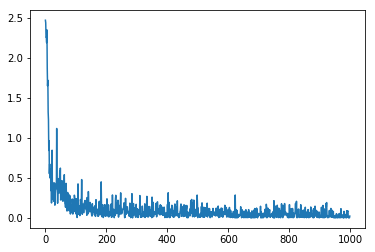

In [18]:
import matplotlib.pyplot as plt

plt.plot(result_train['iteration'], result_train['loss'])

(0, 1000)

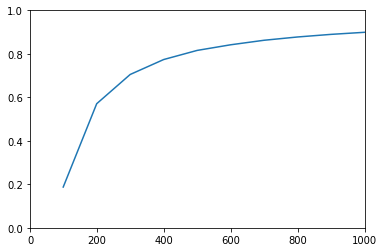

In [19]:
plt.plot(result_test['iteration'], result_test['accuracy'])
plt.ylim((0,1))
plt.xlim((0,1000))

# Dumping of results and logging

By default if unit has `varaibles` or `returns` then results will be dumped at last iteration. But there is unit parameter `dump` that allows to save result not only in the end. It defines as `execute` parameter. For example, dump train results each 200 iterations. Besides, each research has log file. In order to add information about unit execution and dumping into log, define `logging=True`.

In [20]:
research = (Research()
    .pipeline(root=train_root, branch=train_template, variables='loss', name='train', dump='%200')
    .pipeline(root=test_root, branch=test_template,
              variables='accuracy', name='test', run=True, execute='%100', import_from='train', logging=True)
    .grid(grid)
    .function(get_accuracy, returns='accuracy', name='test_accuracy', execute='%100', pipeline='test')
)

In [21]:
research.run(n_reps=2, n_iters=1000, workers=2, branches=2, gpu=[0,1,2,3], name='my_research', progress_bar=True)

../../dataset/research/research.py:326: UserWarning: Research with name my_research already exists. That research will be renamed to my_research_1
  "Research with name {} already exists. That research will be renamed to {}".format(name, dirname)


Research my_research_1 is starting...


  0%|          | 0/4000 [00:00<?, ?it/s]

Distributor has 4 jobs with 1000 iterations. Totally: 4000
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



  1%|▏         | 52/4000 [00:30<38:40,  1.70it/s]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



 50%|█████     | 2000/4000 [02:14<02:14, 14.84it/s]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



 52%|█████▏    | 2077/4000 [02:30<02:19, 13.82it/s]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



100%|██████████| 4000/4000 [04:11<00:00, 15.88it/s]


# Functions on root

All functions and pipelines if `branches > 0` executed in parallel threads so sometime it can be a problem. In order to allow run function in main thread there exists parameter `on_root`. Function that will be added with `on_root=True` will get `iteration`, `experiments` and `kwargs`. `experiments` is a list of experiments that was defined above (`OrderedDict` of `ExecutableUnits`). Simple example of usage:

In [22]:
def on_root(iteration, experiments):
    print("On root", iteration)

In [23]:
research = (Research()
    .function(on_root, on_root=True, execute=10, logging=True)
    .pipeline(root=train_root, branch=train_template, variables='loss', name='train')
    .pipeline(root=test_root, branch=test_template,
              variables='accuracy', name='test', run=True, execute='%100', import_from='train', logging=True)
    .grid(grid)
    .function(get_accuracy, returns='accuracy', name='test_accuracy', execute='%100', pipeline='test')
)

That function will be executed just one time on 10 iteration and will be executed one time for all branches in task.

In [24]:
research.run(n_reps=1, n_iters=100, workers=2, branches=2, gpu=[0,1,2,3], name='my_research', progress_bar=True)

../../dataset/research/research.py:326: UserWarning: Research with name my_research already exists. That research will be renamed to my_research_2
  "Research with name {} already exists. That research will be renamed to {}".format(name, dirname)


Research my_research_2 is starting...


  0%|          | 0/200 [00:00<?, ?it/s]

Distributor has 2 jobs with 100 iterations. Totally: 200


  0%|          | 1/200 [00:20<1:07:36, 20.38s/it]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



  6%|▌         | 11/200 [00:29<08:29,  2.70s/it]

On root 10


 10%|▉         | 19/200 [00:30<04:47,  1.59s/it]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.


 10%|▉         | 19/200 [00:30<04:47,  1.59s/it]

 55%|█████▌    | 110/200 [00:36<00:29,  3.05it/s]

On root 10


100%|██████████| 200/200 [00:46<00:00,  4.34it/s]
